# Initialisation

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu" #Use CPU

# Data

In [31]:
Seed = 321
batch_size = 1000
C1, H1, W1, K = 3, 32, 32, 10

import ssl #Fixes: CERTIFICATE_VERIFY_FAILED
ssl._create_default_https_context = ssl._create_unverified_context
train_ds = torchvision.datasets.CIFAR10(root = 'Data', train = True, download = True, transform = torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.CIFAR10(root = 'Data', train = False, download = True, transform = torchvision.transforms.ToTensor())
classes = train_ds.classes
train = torch.utils.data.DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True)
test = torch.utils.data.DataLoader(dataset = test_ds, batch_size = batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


# Model

## Architecture

In [32]:
class NeuralNet(nn.Module):
    def __init__(self, relu_param, elu_param, H1, W1, K, kernel_size, stride, padding, dilation, pool, pool_dilation, pool_stride, nonlinearities, widths, has_bias, dropout):
        super(NeuralNet, self).__init__()
        self.relu_param = relu_param
        self.elu_param = elu_param
        self.H1 = H1
        self.W1 = W1
        self.K = K
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.pool = pool
        self.pool_dilation = pool_dilation
        self.pool_stride = pool_stride
        self.nonlinearities = nonlinearities
        self.widths = widths
        self.has_bias = has_bias
        self.dropout = dropout
        
        self.CNN = nn.ModuleList([
            nn.Conv2d(in_channels = self.widths[0], out_channels = self.widths[1], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, dilation = self.dilation, bias = self.has_bias[0]),
            self.apply_nonlinearity(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.MaxPool2d(kernel_size = self.pool, dilation = self.pool_dilation, stride = self.pool_stride),
            
            nn.Conv2d(in_channels = self.widths[1], out_channels = self.widths[1], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, dilation = self.dilation, bias = self.has_bias[0]),
            self.apply_nonlinearity(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.MaxPool2d(kernel_size = self.pool, dilation = self.pool_dilation, stride = self.pool_stride)
        ])
        
        self.FFNN = nn.ModuleList([
            nn.Linear(in_features = int(((self.H1/self.pool)/2) * ((self.W1/self.pool)/2) * widths[1]), out_features = self.widths[2], bias = self.has_bias[1]),
            self.apply_nonlinearity(1),
            nn.Dropout(p = self.dropout[1], inplace = False),
            
            nn.Linear(in_features = self.widths[2], out_features = self.widths[3], bias = self.has_bias[2]),
            self.apply_nonlinearity(2),
            nn.Dropout(p = self.dropout[2], inplace = False),
            
            nn.Linear(in_features = self.widths[3], out_features = self.widths[4], bias = self.has_bias[3]),
            self.apply_nonlinearity(3),
            nn.Dropout(p = self.dropout[3], inplace = False),
        ])
        
        self.output = nn.Linear(in_features = self.widths[4], out_features = self.K, bias = self.has_bias[4])
        
    def apply_nonlinearity(self, layer):
        res = None
        if (self.nonlinearities[layer] == "relu"):
            res = nn.ReLU() if (self.relu_param == 0) else self.layers.append(nn.LeakyReLU(negative_slope = self.relu_param))
        elif (self.nonlinearities[layer] == "tanh"):
            res = nn.Tanh()
        elif (self.nonlinearities[layer] == "relu6"):
            res = nn.ReLU6()
        elif (self.nonlinearities[layer] == "sigmoid"):
            res = nn.Sigmoid()
        elif (self.nonlinearities[layer] == "tanh"):
            res = nn.Tanh()
        elif (self.nonlinearities[layer] == "elu"):
            res = nn.ELU(alpha = self.elu_param)
        return res
        
    def forward(self, x):
        for i in range(8):
            x = self.CNN[i](x)
        x = x.view(x.shape[0], -1)
        for i in range(9):
            x = self.FFNN[i](x)
        x = self.output(x)
        
        return x

In [47]:
def gradient_descent(model, criterion, optimiser, train, test, iterations):
    model = model.to(device)
    train_losses, test_losses = np.zeros(iterations), np.zeros(iterations)
    
    for iteration in range(iterations):
        train_loss = []
        
        for inputs, targets in train:
            inputs = inputs.to(device)
            targets = targets.to(device).long()            
            model.train()
            optimiser.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
        
        test_loss, test_accuracy, test_auc, test_f1 = [], [], [], []
        for inputs, targets in test:
            inputs = inputs.to(device)
            targets = targets.to(device).long()            
            
            model.eval()
            with torch.no_grad():
                y_probs = model(inputs)

                cur_test_loss = criterion(y_probs, targets).item()
                y_probs = nn.Softmax(dim = 1)(y_probs)
                _, y_hat = torch.max(y_probs, 1)
                y_probs = y_probs.cpu().numpy()
                y_hat = y_hat.cpu().numpy()
                targets = targets.cpu().numpy()

                cur_test_accuracy = np.mean(y_hat == targets)
                cur_test_auc = roc_auc_score(targets, y_probs, multi_class = "ovr", average = 'weighted')
                cur_test_f1 = f1_score(targets, y_hat, average = 'weighted')
            
            test_loss.append(cur_test_loss)
            test_accuracy.append(cur_test_accuracy)
            test_auc.append(cur_test_auc)
            test_f1.append(cur_test_f1)
        test_loss =  np.mean(test_loss)
        test_accuracy = np.mean(test_accuracy)
        test_auc = np.mean(test_auc)
        test_f1 = np.mean(test_f1)

        train_losses[iteration] = train_loss
        test_losses[iteration] = test_loss
        
        if (iteration + 1) % 1 == 0 or iteration == 0 or iteration == iterations - 1:
            print(f'Iteration {iteration + 1}/{iterations}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f} | Acc: {test_accuracy:.3f}, AUC: {test_auc:.3f}, F1: {test_f1:.3f}')
    
    return train_losses, test_losses

## Hyper Parameters

In [60]:
kernel_size = 3
stride = 1
dilation = 1
padding = 1
pool = 2
pool_dilation = 1
pool_stride = pool
relu_param = 0
elu_param = 0.8
widths = [C1, 25, 64, 32, 16]
nonlinearities = ["relu"] * 4
dropout = [0.0] * 4
has_bias = [True] * 5
l2_lamda = 0.0
mu = 0.9

In [61]:
train_losses = np.array([])
test_losses = np.array([])
criterion = nn.CrossEntropyLoss()
model = NeuralNet(relu_param, elu_param, H1, W1, K, kernel_size, stride, padding, dilation, pool, pool_dilation, pool_stride, nonlinearities, widths, has_bias, dropout).to(device)
model

NeuralNet(
  (CNN): ModuleList(
    (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.0, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FFNN): ModuleList(
    (0): Linear(in_features=1600, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
  )
  (output): Linear(in_features=16, out_features=10, bias=True)
)

In [62]:
learning_rate = 1e-2
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

In [64]:
iterations = 20
new_train_losses, new_test_losses = gradient_descent(model, criterion, optimiser, train, test, iterations)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)

Iteration 1/15, Train Loss: 0.828, Test Loss: 1.121 | Acc: 0.624, AUC: 0.930, F1: 0.622
Iteration 2/15, Train Loss: 0.806, Test Loss: 1.061 | Acc: 0.640, AUC: 0.935, F1: 0.638
Iteration 3/15, Train Loss: 0.790, Test Loss: 1.070 | Acc: 0.642, AUC: 0.935, F1: 0.639
Iteration 4/15, Train Loss: 0.775, Test Loss: 1.100 | Acc: 0.630, AUC: 0.933, F1: 0.635
Iteration 5/15, Train Loss: 0.762, Test Loss: 1.089 | Acc: 0.641, AUC: 0.934, F1: 0.639
Iteration 6/15, Train Loss: 0.746, Test Loss: 1.114 | Acc: 0.637, AUC: 0.933, F1: 0.635
Iteration 7/15, Train Loss: 0.725, Test Loss: 1.148 | Acc: 0.632, AUC: 0.932, F1: 0.624
Iteration 8/15, Train Loss: 0.693, Test Loss: 1.128 | Acc: 0.643, AUC: 0.934, F1: 0.645
Iteration 9/15, Train Loss: 0.685, Test Loss: 1.141 | Acc: 0.640, AUC: 0.932, F1: 0.637
Iteration 10/15, Train Loss: 0.676, Test Loss: 1.209 | Acc: 0.621, AUC: 0.928, F1: 0.615
Iteration 11/15, Train Loss: 0.681, Test Loss: 1.198 | Acc: 0.633, AUC: 0.931, F1: 0.624
Iteration 12/15, Train Loss: 0

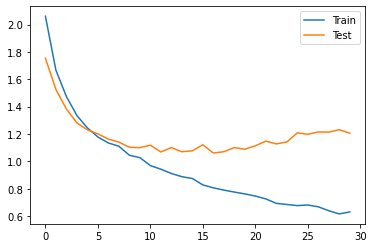

In [65]:
plt.plot(train_losses, label = f"Train")
plt.plot(test_losses, label = f"Test")
plt.legend()
plt.show()

Accuracy: 63.070%. AUC: 0.929, F1: 0.628


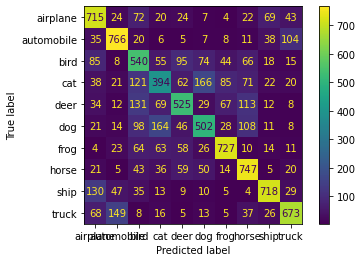

In [66]:
model.eval()
with torch.no_grad():
    model = model.to(device)
    
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in test:
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        
        model.eval()
        with torch.no_grad():
            outputs_prob = model(inputs)
            outputs_prob = nn.Softmax(dim = 1)(outputs_prob)
            _, outputs = torch.max(outputs_prob, 1)
        
        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
        
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    test_Acc = np.mean(Preds == Targets)
    test_AUC = roc_auc_score(Targets, Preds_prob, multi_class = "ovr", average = 'weighted')
    test_F1 = f1_score(Targets, Preds, average = 'weighted')
    print(f'Accuracy: {test_Acc * 100:.3f}%. AUC: {test_AUC:.3f}, F1: {test_F1:.3f}')
    
    ConfusionMatrixDisplay(confusion_matrix(Targets, Preds), display_labels = classes).plot()
    plt.show()

# Hyperparameters 2

In [67]:
kernel_size = 3
stride = 1
dilation = 1
padding = 1
pool = 2
pool_dilation = 1
pool_stride = pool
relu_param = 0
elu_param = 0.8
widths = [C1, 25, 64, 32, 16]
nonlinearities = ["relu"] * 4
dropout = [0.3] * 4
has_bias = [True] * 5
l2_lamda = 0.05
mu = 0.9

In [68]:
train_losses = np.array([])
test_losses = np.array([])
criterion = nn.CrossEntropyLoss()
model = NeuralNet(relu_param, elu_param, H1, W1, K, kernel_size, stride, padding, dilation, pool, pool_dilation, pool_stride, nonlinearities, widths, has_bias, dropout).to(device)
model

NeuralNet(
  (CNN): ModuleList(
    (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FFNN): ModuleList(
    (0): Linear(in_features=1600, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=16, out_features=10, bias=True)
)

In [69]:
learning_rate = 1e-2
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

In [82]:
iterations = 100
new_train_losses, new_test_losses = gradient_descent(model, criterion, optimiser, train, test, iterations)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)

Iteration 1/100, Train Loss: 1.478, Test Loss: 1.410 | Acc: 0.522, AUC: 0.894, F1: 0.516
Iteration 2/100, Train Loss: 1.493, Test Loss: 1.373 | Acc: 0.527, AUC: 0.897, F1: 0.511
Iteration 3/100, Train Loss: 1.482, Test Loss: 1.358 | Acc: 0.545, AUC: 0.901, F1: 0.534
Iteration 4/100, Train Loss: 1.482, Test Loss: 1.420 | Acc: 0.526, AUC: 0.894, F1: 0.525
Iteration 5/100, Train Loss: 1.494, Test Loss: 1.374 | Acc: 0.530, AUC: 0.896, F1: 0.520
Iteration 6/100, Train Loss: 1.473, Test Loss: 1.359 | Acc: 0.540, AUC: 0.901, F1: 0.530
Iteration 7/100, Train Loss: 1.486, Test Loss: 1.406 | Acc: 0.522, AUC: 0.896, F1: 0.515
Iteration 8/100, Train Loss: 1.492, Test Loss: 1.487 | Acc: 0.490, AUC: 0.884, F1: 0.489
Iteration 9/100, Train Loss: 1.490, Test Loss: 1.352 | Acc: 0.539, AUC: 0.895, F1: 0.525
Iteration 10/100, Train Loss: 1.494, Test Loss: 1.349 | Acc: 0.549, AUC: 0.900, F1: 0.549
Iteration 11/100, Train Loss: 1.469, Test Loss: 1.364 | Acc: 0.528, AUC: 0.897, F1: 0.517
Iteration 12/100, T

Iteration 93/100, Train Loss: 1.447, Test Loss: 1.346 | Acc: 0.540, AUC: 0.901, F1: 0.526
Iteration 94/100, Train Loss: 1.472, Test Loss: 1.337 | Acc: 0.544, AUC: 0.902, F1: 0.534
Iteration 95/100, Train Loss: 1.461, Test Loss: 1.365 | Acc: 0.542, AUC: 0.899, F1: 0.537
Iteration 96/100, Train Loss: 1.475, Test Loss: 1.414 | Acc: 0.505, AUC: 0.891, F1: 0.498
Iteration 97/100, Train Loss: 1.484, Test Loss: 1.370 | Acc: 0.532, AUC: 0.899, F1: 0.513
Iteration 98/100, Train Loss: 1.468, Test Loss: 1.326 | Acc: 0.548, AUC: 0.903, F1: 0.538
Iteration 99/100, Train Loss: 1.456, Test Loss: 1.374 | Acc: 0.538, AUC: 0.899, F1: 0.531
Iteration 100/100, Train Loss: 1.461, Test Loss: 1.337 | Acc: 0.543, AUC: 0.899, F1: 0.524


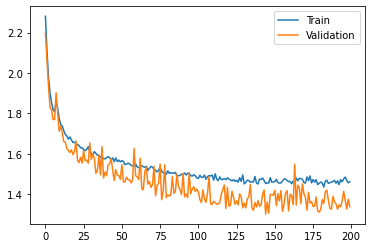

In [83]:
plt.plot(train_losses, label = f"Train")
plt.plot(test_losses, label = f"Validation")
plt.legend()
plt.show()

Accuracy: 54.260%. AUC: 0.899, F1: 0.524


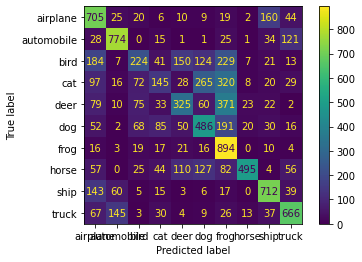

In [84]:
model.eval()
with torch.no_grad():
    model = model.to(device)
    
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in test:
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        
        model.eval()
        with torch.no_grad():
            outputs_prob = model(inputs)
            outputs_prob = nn.Softmax(dim = 1)(outputs_prob)
            _, outputs = torch.max(outputs_prob, 1)
        
        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
    
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    test_Acc = np.mean(Preds == Targets)
    test_AUC = roc_auc_score(Targets, Preds_prob, multi_class = "ovr", average = 'weighted')
    test_F1 = f1_score(Targets, Preds, average = 'weighted')
    print(f'Accuracy: {test_Acc * 100:.3f}%. AUC: {test_AUC:.3f}, F1: {test_F1:.3f}')
    
    ConfusionMatrixDisplay(confusion_matrix(Targets, Preds), display_labels = classes).plot()
    plt.show()

# Hyperparameters 3

In [86]:
kernel_size = 3
stride = 1
dilation = 1
padding = 1
pool = 2
pool_dilation = 1
pool_stride = pool
relu_param = 0
elu_param = 0.8
widths = [C1, 32, 32, 16, 16]
nonlinearities = ["relu", "tanh", "tanh", "tanh"]
dropout = [0.1] * 4
has_bias = [True] * 5
l2_lamda = 0.005
mu = 0.9

In [87]:
train_losses = np.array([])
test_losses = np.array([])
criterion = nn.CrossEntropyLoss()
model = NeuralNet(relu_param, elu_param, H1, W1, K, kernel_size, stride, padding, dilation, pool, pool_dilation, pool_stride, nonlinearities, widths, has_bias, dropout).to(device)
model

NeuralNet(
  (CNN): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FFNN): ModuleList(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
  )
  (output): Linear(in_features=16, out_features=10, bias=True)
)

In [88]:
learning_rate = 1e-2
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

In [92]:
iterations = 20
new_train_losses, new_test_losses = gradient_descent(model, criterion, optimiser, train, test, iterations)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)

Iteration 1/20, Train Loss: 0.947, Test Loss: 1.041 | Acc: 0.642, AUC: 0.935, F1: 0.640
Iteration 2/20, Train Loss: 0.941, Test Loss: 1.026 | Acc: 0.653, AUC: 0.937, F1: 0.650
Iteration 3/20, Train Loss: 0.945, Test Loss: 1.045 | Acc: 0.644, AUC: 0.936, F1: 0.645
Iteration 4/20, Train Loss: 0.955, Test Loss: 1.005 | Acc: 0.656, AUC: 0.939, F1: 0.655
Iteration 5/20, Train Loss: 0.933, Test Loss: 1.019 | Acc: 0.651, AUC: 0.938, F1: 0.650
Iteration 6/20, Train Loss: 0.926, Test Loss: 1.033 | Acc: 0.645, AUC: 0.937, F1: 0.646
Iteration 7/20, Train Loss: 0.930, Test Loss: 1.016 | Acc: 0.652, AUC: 0.938, F1: 0.651
Iteration 8/20, Train Loss: 0.913, Test Loss: 1.005 | Acc: 0.654, AUC: 0.940, F1: 0.656
Iteration 9/20, Train Loss: 0.891, Test Loss: 1.070 | Acc: 0.636, AUC: 0.935, F1: 0.640
Iteration 10/20, Train Loss: 0.916, Test Loss: 1.029 | Acc: 0.648, AUC: 0.939, F1: 0.650
Iteration 11/20, Train Loss: 0.894, Test Loss: 1.024 | Acc: 0.650, AUC: 0.938, F1: 0.647
Iteration 12/20, Train Loss: 0

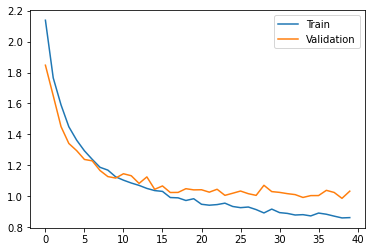

In [95]:
plt.plot(train_losses, label = f"Train")
plt.plot(test_losses, label = f"Validation")
plt.legend()
plt.show()

Accuracy: 64.880%. AUC: 0.938, F1: 0.647


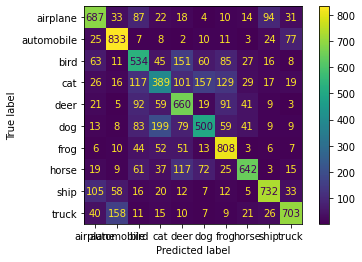

In [96]:
model.eval()
with torch.no_grad():
    model = model.to(device)
    
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in test:
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        
        model.eval()
        with torch.no_grad():
            outputs_prob = model(inputs)
            outputs_prob = nn.Softmax(dim = 1)(outputs_prob)
            _, outputs = torch.max(outputs_prob, 1)
        
        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
    
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    test_Acc = np.mean(Preds == Targets)
    test_AUC = roc_auc_score(Targets, Preds_prob, multi_class = "ovr", average = 'weighted')
    test_F1 = f1_score(Targets, Preds, average = 'weighted')
    print(f'Accuracy: {test_Acc * 100:.3f}%. AUC: {test_AUC:.3f}, F1: {test_F1:.3f}')
    
    ConfusionMatrixDisplay(confusion_matrix(Targets, Preds), display_labels = classes).plot()
    plt.show()